# Movie Reviews Analysis Sentiment ML

## 1. Preparations

### 1.1 Library Preparations

In [1]:
pip install pandas nltk spacy beautifulsoup4 tqdm scikit-learn matplotlib wordcloud gensim

Bad pipe message: %s [b"D\xfa\x1dS \xe7\xa1\xf0\x93h\x88\x9e\xe5\xc8\xa7m\x00\xb1 \xdd8_\x00\x16\x94y\x04\x1a\xc8U\xfb\xa9iU\x0e\xfa\xd3\x81\xf7\x93\xbf\x8d\x05\x10v\x14\x0c\xe0\x10\xad'\x00\x1a\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\t\xc0\x13\xc0\n\xc0\x14\x13\x01\x13\x02\x13\x03\x01\x00\x05A\x00\x0b\x00\x02\x01\x00\xff\x01\x00\x01\x00\x00\x17\x00\x00\x00\x12\x00\x00\x00\x05\x00\x05\x01\x00\x00\x00\x00\x00\n\x00\x0c\x00\n\x11\xec\x00\x1d\x00\x17\x00\x18\x00\x19\x00\r\x00\x1a\x00\x18\x08\x04\x04\x03\x08\x07\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x05\x03\x06\x03\x02\x01\x02\x03\x00+\x00\x05\x04\x03\x04\x03\x03\x003\x04\xea\x04\xe8\x11\xec\x04\xc0\xb5Z?\xd5\xbavg\x86\xa5\xf1\xa9\xcc\xfcl\xaf\xe8\xa83x\\\xc3M\xac,\xaaD4\xa4`\xa1("]
Bad pipe message: %s [b';\x0bO\x04\x06G<6#\xf2i\x93\xe4\x8a_!\xb4F_u\x82\x8b\xc8\xba\xb8T\xb7\xf6\x86\xce\xe9|`\xa8\x17W\x00R\xc5\xee\xd64\xb5Az\x1d*\xab\xbev<\xff\x99w\x8dl:\xbdCz\xfa\xda\xc5X\\oW\xb7_Z[\x8b\x077\xcc\xd7&U\xd4\xfami4\x05\xe8C\xab,', b"?\xd81

INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
  Using cached scipy-1.15.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.15.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.7 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


### 1.2 Dataset Preparations

In [2]:
import pandas as pd

df = pd.read_csv('datasets/raw/IMDB_dataset.csv')
df.sample(10)

,review,sentiment
16467,Alien Warrior (or King of The Streets) is one ...,positive
15202,Frank Sinatra starred in this odd little short...,positive
18047,"Yes, talk about bad sequels. Rick Moranis star...",negative
48348,"Yes, my summary just about tells it all.<br />...",negative
17748,BEWARE SPOILERS. This movie was okay. Goldie H...,positive
32095,Director and auteur Jean-Pierre Rappenau was 8...,positive
28640,Tim Meadows has to be the most underrated of S...,positive
49469,"Sure, most of the slasher films of the 1980's ...",negative
10363,Here are the matches . . . (adv. = advantage)<...,negative
13894,You can do a lot with a little cash. Blair Wit...,positive


In [3]:
df.count()

review       50000
sentiment    50000
dtype: int64

In [4]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

### 1.3 Dataset Cleaning

#### 1.3.1 Cleaning

In [6]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.4 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
import re
import string
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from html import unescape

In [8]:
# Download NLTK
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load spacy model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt_tab to /home/user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
# Stopwords & lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = unescape(text)
    
    # 1. Remove HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 3. Remove emoji / non-ASCII
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    # 4. Lowercase
    text = text.lower()
    
    # 5. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 6. Tokenization
    tokens = word_tokenize(text)
    
    # 7. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # 8. Lemmatization using spaCy
    doc = nlp(" ".join(tokens))
    tokens = [token.lemma_ for token in doc]
    
    # 9. Normalize whitespace & join back to string
    clean_text = " ".join(tokens)
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    
    return clean_text

In [11]:
df_test = df.iloc[1]['review']
df_test

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [12]:
df_cleaned_test = preprocess_text(df_test)
df_cleaned_test

'wonderful little production filming technique unassume oldtimebbc fashion give comfort sometimes discomforte sense realism entire piece actor extremely well choose michael sheen get polari voice pat truly see seamless editing guide reference williams diary entry well worth watching terrificly write perform piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional dream technique remain solid disappear play knowledge sense particularly scene concern orton halliwell set particularly flat halliwell mural decorate every surface terribly well do'

In [ ]:
# df['clean_review'] = df['review'].apply(preprocess_text)
# df['clean_review'].sample(10)

In [13]:
positive_df = df[df['sentiment'] == 'positive'].sample(n=500, random_state=42)
negative_df = df[df['sentiment'] == 'negative'].sample(n=500, random_state=42)

# Gabungkan dan shuffle
df_sample = pd.concat([positive_df, negative_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Cek distribusi
print(df_sample['sentiment'].value_counts())
df_sample.head()

sentiment
negative    500
positive    500
Name: count, dtype: int64


,review,sentiment
0,"For Daniel Auteuil, `Queen Margot' was much be...",negative
1,Spoilers abound. You have been warned.<br /><b...,negative
2,"Where do I start? The plot of the movie, which...",negative
3,There was a genie played by Shaq His name was ...,negative
4,Its a very good comedy movie.Ijust liked it.I ...,positive


In [14]:
from tqdm import tqdm
tqdm.pandas()

df_sample['clean_review'] = df_sample['review'].progress_apply(preprocess_text)
df_sample.sample(5)

100%|██████████| 1000/1000 [00:43<00:00, 23.24it/s]


,review,sentiment,clean_review
302,Forbidden Planet rates as landmark in science ...,positive,forbid planet rate landmark science fiction ca...
132,"When I watched this film the first time, it wa...",positive,watch film first time tape copy title wasis ca...
636,"for many and many years, gaijin have visited j...",positive,many many year gaijin visit japan learn martia...
270,"This is a film that has it all, the dashing he...",positive,film dash hero beautiful damsel distress noble...
784,'Steamboat Willie (1928)' is often erroneously...,positive,steamboat willie 1928 often erroneously tout f...


In [15]:
df_sample.to_csv('datasets/cleaned/IMDB_dataset_1000_cleaned.csv')

#### 1.3.2 Visualizing

In [23]:
df_sample.sample(10)

,review,sentiment,clean_review
3,There was a genie played by Shaq His name was ...,negative,genie play shaq name kazaam whack rhyme corny ...
316,"Another ""must have"" film. Henry Brandon is a f...",positive,another must film henry brandon favorite surpr...
489,This is why I still have nightmares.<br /><br ...,positive,still nightmaresthis terrifying film musical c...
259,I like this film for several reasons. I have a...,positive,like film several reason soft spot film intric...
228,This movie is filled with so many idiotic mome...,negative,movie fill many idiotic moment wonder ever get...
543,Yet another foreign war movie that puts hollyw...,positive,yet another foreign war movie put hollywood sh...
910,I am a huge fan of warrior movies. Some of my ...,negative,huge fan warrior movie favorite braveheart tro...
502,Nice character development in a pretty cool mi...,positive,nice character development pretty cool milieu ...
276,Liam Neeson portrays the Scottish legend Rober...,positive,liam neeson portray scottish legend robert roy...
819,"The biggest National Lampoon hit remains ""Anim...",negative,big national lampoon hit remain animal house r...


In [17]:
df_sample['sentiment'].value_counts()

sentiment
negative    500
positive    500
Name: count, dtype: int64

In [24]:
import matplotlib.pyplot as plt
from collections import Counter

# Pisahkan data berdasarkan sentimen
positive_reviews = df_sample[df_sample['sentiment'] == 'positive']['clean_review']
negative_reviews = df_sample[df_sample['sentiment'] == 'negative']['clean_review']

# Gabungkan teks jadi satu string per kategori
positive_words = " ".join(positive_reviews).split()
negative_words = " ".join(negative_reviews).split()

# Hitung frekuensi kata
positive_counts = Counter(positive_words).most_common(10)
negative_counts = Counter(negative_words).most_common(10)


##### Top 10 Most Word

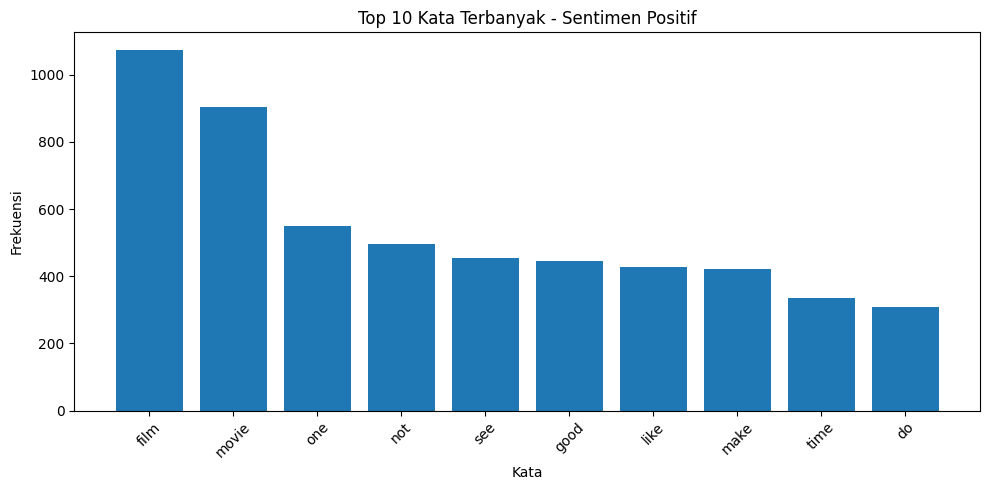

In [25]:
# Visualisasi positif
plt.figure(figsize=(10, 5))
words, counts = zip(*positive_counts)
plt.bar(words, counts)
plt.title("Top 10 Kata Terbanyak - Sentimen Positif")
plt.xlabel("Kata")
plt.ylabel("Frekuensi")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

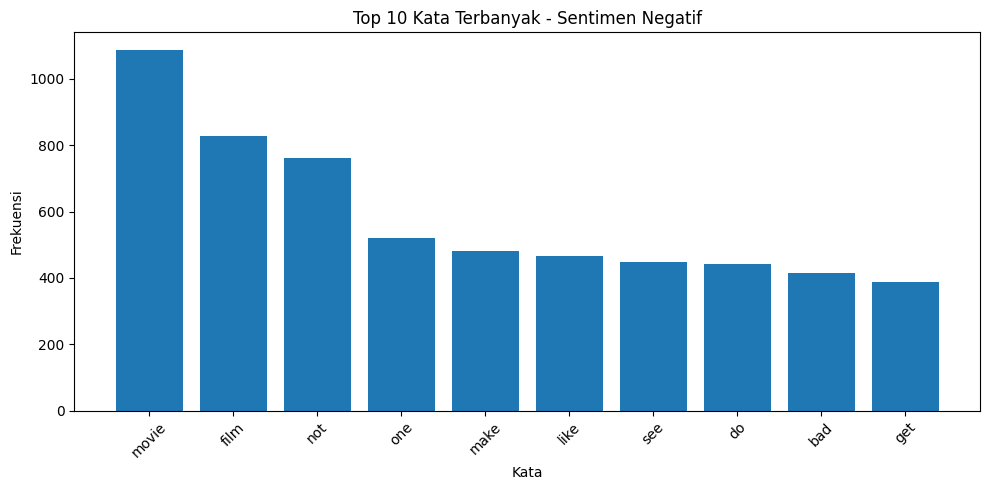

In [26]:
# Visualisasi negatif
plt.figure(figsize=(10, 5))
words, counts = zip(*negative_counts)
plt.bar(words, counts)
plt.title("Top 10 Kata Terbanyak - Sentimen Negatif")
plt.xlabel("Kata")
plt.ylabel("Frekuensi")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Wordcloud

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ambil semua teks per sentimen
positive_text = " ".join(df_sample[df_sample['sentiment'] == 'positive']['clean_review'])
negative_text = " ".join(df_sample[df_sample['sentiment'] == 'negative']['clean_review'])

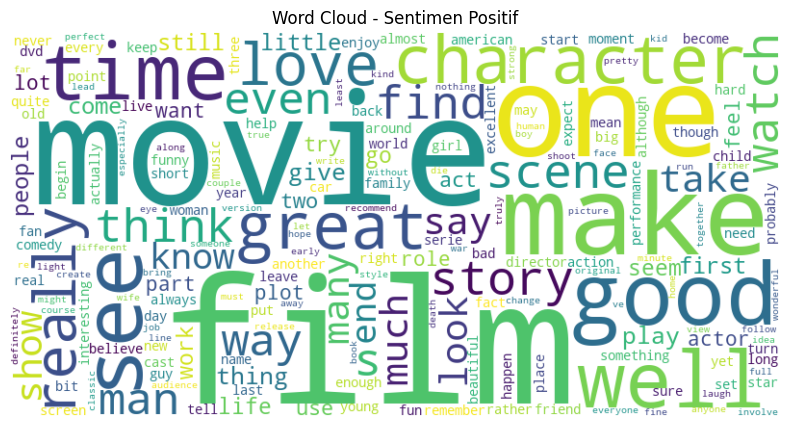

In [28]:
# WordCloud - Sentimen Positif
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Sentimen Positif')
plt.show()

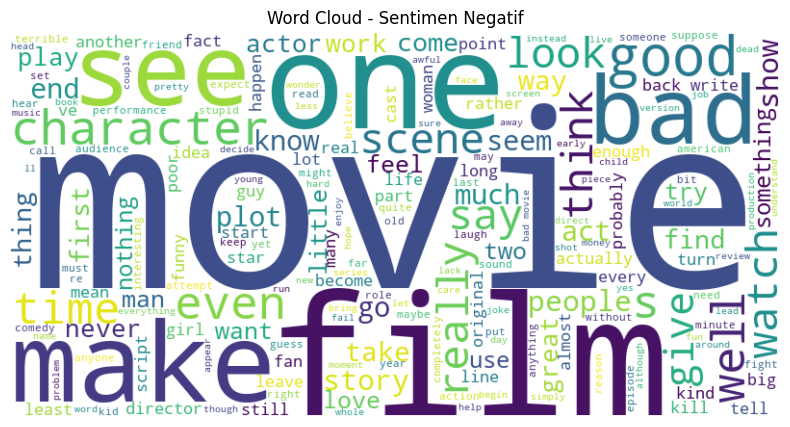

In [29]:
# WordCloud - Sentimen Negatif
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Sentimen Negatif')
plt.show()

### 1.4 Dataset Preprocessing

In [30]:
import pandas as pd

df = pd.read_csv('datasets/cleaned/IMDB_dataset_1000_cleaned.csv')
df.sample(10)

,Unnamed: 0,review,sentiment,clean_review
339,339,Perhaps I couldn't find the DVD menu selection...,negative,perhaps could not find dvd menu selection plot...
147,147,"""Xizao"", is the tale about the clash of modern...",positive,xizao tale clash modern life ancient tradition...
785,785,A FROLICS OF YOUTH Short Subject.<br /><br />A...,positive,frolic youth short subjecta teenager embarrass...
960,960,This movie is difficult to watch in our fast-p...,positive,movie difficult watch fastpaced culture 21st c...
278,278,"Exclusively for Coop's lovers, though Clint Ea...",positive,exclusively coop lover though clint eastwood s...
697,697,I love the Thackeray novel on which this film ...,positive,love thackeray novel film base modern version ...
104,104,i though this film was okay.i din't think it w...,negative,though film okayi dint think greatit bit slow ...
598,598,Altered Species starts one Friday night in Los...,negative,altered specie start one friday night los ange...
308,308,This movie is not only poorly scripted and dir...,negative,movie poorly script direct simply distasteful ...
639,639,Corridors of time. The movie you can watch if ...,negative,corridor time movie watch you re look sophisti...


#### 1.4.1 TF-IDF Vectorizing

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_vectors = tfidf_vectorizer.fit_transform(df['clean_review'])
tfidf_vectors

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 78883 stored elements and shape (1000, 5000)>

In [32]:
tfidf_vectorizer.get_feature_names_out()[:20]

array(['10', '100', '1000', '10000', '100000', '110', '13th', '146',
       '1928', '1930s', '1932', '1940', '1950', '1950s', '1959', '1960',
       '1970', '1970s', '1975', '1978'], dtype=object)

##### Visualizing: Top Words

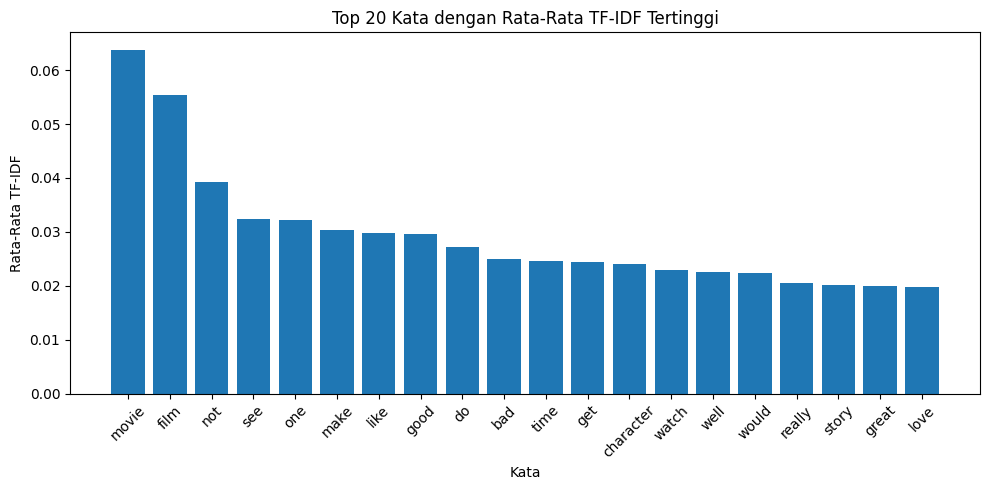

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Ambil rata-rata skor TF-IDF tiap kata (kolom)
mean_tfidf = tfidf_vectors.mean(axis=0).A1  # .A1 untuk konversi matrix ke array 1D
features = tfidf_vectorizer.get_feature_names_out()

# Buat DataFrame
tfidf_scores = pd.DataFrame({'word': features, 'mean_tfidf': mean_tfidf})
top_words = tfidf_scores.sort_values(by='mean_tfidf', ascending=False).head(20)

# Visualisasi
plt.figure(figsize=(10, 5))
plt.bar(top_words['word'], top_words['mean_tfidf'])
plt.title("Top 20 Kata dengan Rata-Rata TF-IDF Tertinggi")
plt.xlabel("Kata")
plt.ylabel("Rata-Rata TF-IDF")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

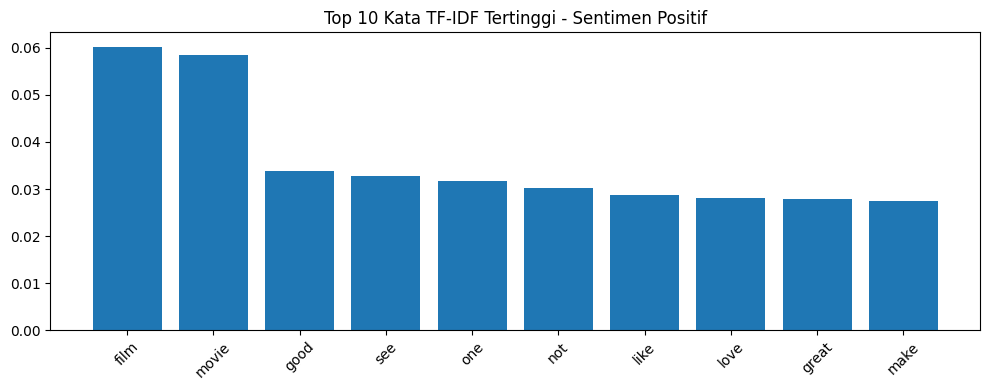

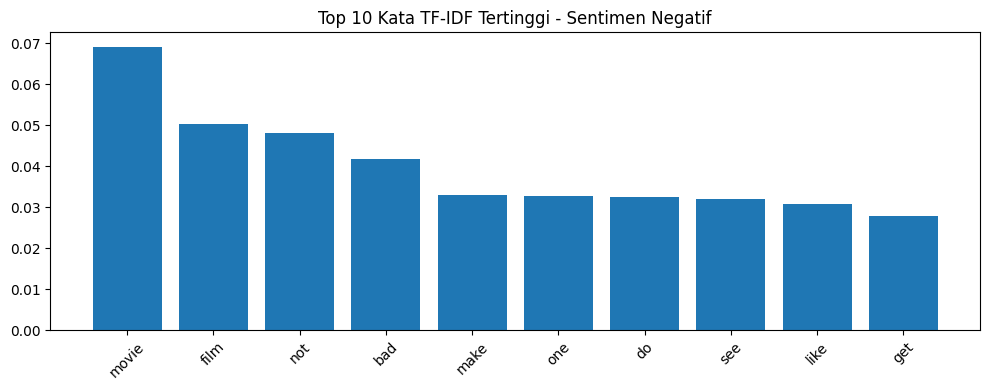

In [34]:
# Buat DataFrame dari tfidf_vectors
tfidf_df = pd.DataFrame(tfidf_vectors.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['sentiment'] = df_sample['sentiment'].values

# Rata-rata per sentimen
mean_pos = tfidf_df[tfidf_df['sentiment'] == 'positive'].drop('sentiment', axis=1).mean()
mean_neg = tfidf_df[tfidf_df['sentiment'] == 'negative'].drop('sentiment', axis=1).mean()

# Top 10 kata dari masing-masing
top_pos = mean_pos.sort_values(ascending=False).head(10)
top_neg = mean_neg.sort_values(ascending=False).head(10)

# Visualisasi Positif
plt.figure(figsize=(10, 4))
plt.bar(top_pos.index, top_pos.values)
plt.title("Top 10 Kata TF-IDF Tertinggi - Sentimen Positif")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualisasi Negatif
plt.figure(figsize=(10, 4))
plt.bar(top_neg.index, top_neg.values)
plt.title("Top 10 Kata TF-IDF Tertinggi - Sentimen Negatif")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Visualizing: Wordcloud

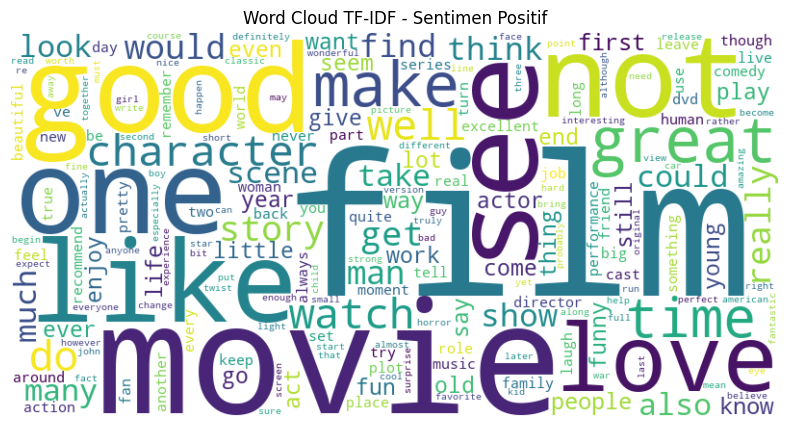

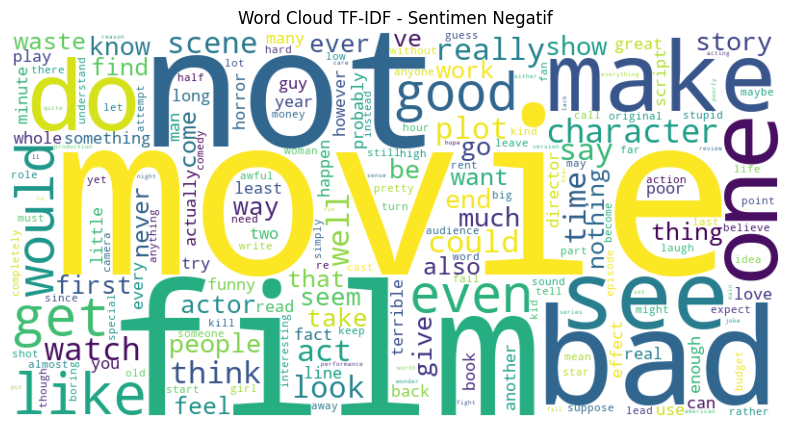

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Buat DataFrame dari TF-IDF vectors
tfidf_df = pd.DataFrame(tfidf_vectors.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['sentiment'] = df['sentiment'].values

# Hitung rata-rata nilai TF-IDF per kata untuk tiap sentimen
mean_pos = tfidf_df[tfidf_df['sentiment'] == 'positive'].drop(columns=['sentiment']).mean()
mean_neg = tfidf_df[tfidf_df['sentiment'] == 'negative'].drop(columns=['sentiment']).mean()

# WordCloud - Positif
wc_pos = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(mean_pos.to_dict())
plt.figure(figsize=(10, 5))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud TF-IDF - Sentimen Positif')
plt.show()

# WordCloud - Negatif
wc_neg = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(mean_neg.to_dict())
plt.figure(figsize=(10, 5))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud TF-IDF - Sentimen Negatif')
plt.show()

#### 1.4.2 FastText Vectorizing

##### Pre-Trained Model

In [74]:
!cd models/libs && wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

In [ ]:
from gensim.models import KeyedVectors

# Load dari .vec.gz (pertama kali, memang lama)
model = KeyedVectors.load_word2vec_format("models/libs/cc.en.300.vec.gz", binary=False)

# Simpan dalam format binary untuk penggunaan selanjutnya
model.save("models/libs/cc.en.300.kv")

In [11]:
from gensim.models import KeyedVectors

# Load pre-trained FastText vectors (butuh beberapa menit)
fasttext_model = KeyedVectors.load_word2vec_format("models/libs/cc.en.300.vec.gz", binary=False)

##### Train Own Model

In [30]:
import pandas as pd

df = pd.read_csv("datasets/cleaned/IMDB_dataset_1000_cleaned.csv")
df_sample.sample(5)